# PART I : Training and evaluating a DistilBERT model

In [2]:
# Step 1: Install Required Libraries
#!python -m venv .venv
!pip install transformers datasets scikit-learn pandas tqdm -q
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu114
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machin

In [3]:
# Step 2: Download and Extract the IMDb Dataset
import os
import tarfile
import urllib.request
import torch
from torch.utils.data import DataLoader

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()
    print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


In [4]:
# Step 3: Load and Format the Dataset into a Pandas DataFrame
import glob
import pandas as pd

def load_imdb_data(data_dir):
    def load_dir(path, label):
        texts = []
        for filepath in glob.glob(os.path.join(path, "*.txt")):
            with open(filepath, encoding='utf-8') as f:
                texts.append(f.read())
        return pd.DataFrame({"text": texts, "label": label})

    pos = load_dir(os.path.join(data_dir, "pos"), 1)
    neg = load_dir(os.path.join(data_dir, "neg"), 0)
    return pd.concat([pos, neg])

train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df


,text,label
0,I don't know what movie some of these other pe...,1
1,The plot it's not so original. If someone saw ...,0
2,I loved this movie! It was all I could do not ...,1
3,Really bad movie. Maybe the worst I've ever se...,0
4,What a terrible film.<br /><br />It starts wel...,0
...,...,...
24995,"Well, what can i say about this movie. I'm spe...",0
24996,"Xiao Chen Zhi Chun is a great movie, not only ...",1
24997,A recent viewing of THAT'S ENTERTAINMENT has g...,1
24998,"The master of cheap erotic horror, Rolfe Kanef...",0


In [6]:
# Step 4: Convert to HuggingFace Dataset Format
from datasets import Dataset
from sklearn.model_selection import train_test_split

# 1. Split train_df into train and eval sets
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    train_df["text"].tolist(),
    train_df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

# 2. Create Dataset objects
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
eval_dataset = Dataset.from_dict({"text": eval_texts, "label": eval_labels})
test_dataset = Dataset.from_pandas(test_df)

In [10]:
# Step 5: Tokenization using DistilBERT
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_and_get_length(batch):
    tokenized = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)
    tokenized["num_tokens"] = [len(tokenizer.tokenize(t)) for t in batch["text"]]
    return tokenized

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_tokenized = train_dataset.map(tokenize_and_get_length, batched=True)
eval_tokenized = eval_dataset.map(tokenize_and_get_length, batched=True)
test_tokenized = test_dataset.map(tokenize_and_get_length, batched=True)

2025-04-26 14:08:24.676533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745676504.863731      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745676504.924602      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [11]:
# Step 6: Prepare Torch Datasets
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label", "num_tokens"])

In [14]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 104.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [15]:
import transformers
print(transformers.__version__)

4.51.1


In [18]:
# Step 7: Load BERT and Trainer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import accelerate
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device:", device)

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./bert_results",
    #evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=500,
    #evaluation_strategy="steps",  # Evaluate during training
    eval_steps=500,  # Evaluate every 500 steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add custom metrics here
)

Training on device: cuda


/tmp/ipykernel_31/2515956134.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
# Step 8: Fine-Tune BERT
import wandb
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paul-d10 (paul-d10-ensae-alumni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
500,0.395200
1000,0.328600
1500,0.310600
2000,0.300100
2500,0.272500
3000,0.156200
3500,0.160700
4000,0.155800
4500,0.147200
5000,0.142300


TrainOutput(global_step=5000, training_loss=0.2369235534667969, metrics={'train_runtime': 1472.4488, 'train_samples_per_second': 27.166, 'train_steps_per_second': 3.396, 'total_flos': 5298695946240000.0, 'train_loss': 0.2369235534667969, 'epoch': 2.0})

In [20]:
# Save model after training
model_save_path = "./imdb_sentiment_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Save training arguments using the to_json_string method instead
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model


In [21]:
# Step 9: Predict Scores for Test Set
from tqdm import tqdm

test_loader = DataLoader(test_tokenized, batch_size=16)
model.eval()

all_texts = test_df["text"].tolist()
all_true_labels = test_df["label"].tolist()
all_preds = []
all_scores = []
all_token_counts = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # Positive class score
        all_token_counts.extend(batch["num_tokens"].cpu().numpy())  # Original token count


100%|██████████| 1563/1563 [03:16<00:00,  7.95it/s]


In [22]:
# Step 10: Create Final Scored DataFrame
import numpy as np

# Final DataFrame
scored_df = pd.DataFrame({
    "review": all_texts,
    "true_label": all_true_labels,
    "predicted_label": all_preds,
    "positive_score": all_scores,
    "num_tokens": all_token_counts
})

# Adding a 'confidence' column
scored_df["confidence"] = np.where(scored_df["predicted_label"] == 1, scored_df["positive_score"], 1 - scored_df["positive_score"])

# Optional: Add "was_truncated" flag (if > 512 tokens)
scored_df["was_truncated"] = scored_df["num_tokens"] > 512

scored_df.head()

scored_df.to_csv('predictions_full_results.csv', index=False)

np.save("preds.npy", np.array(all_preds))
np.save("scores.npy", np.array(all_scores))
print(f"Predictions and scores saved.")

Predictions and scores saved.


In [23]:
# Step 11 : Compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(scored_df["true_label"], scored_df["predicted_label"])
precision, recall, f1, _ = precision_recall_fscore_support(scored_df["true_label"], scored_df["predicted_label"], average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9274
Precision: 0.9269
Recall: 0.9279
F1 Score: 0.9274


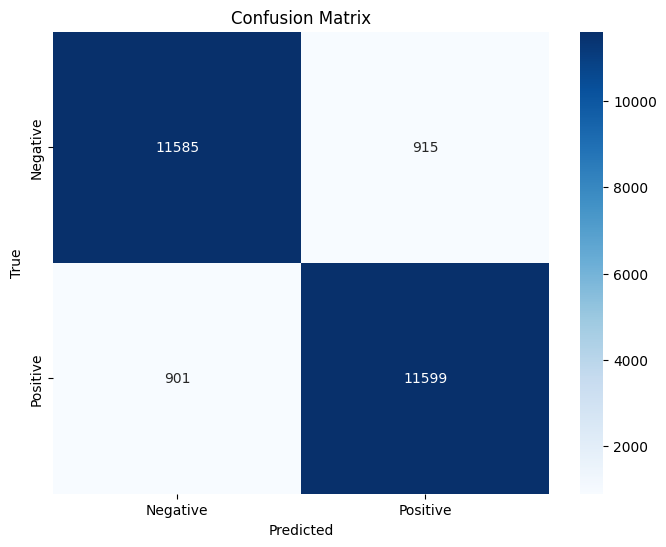

In [24]:
# Create confusion matrix
cm = confusion_matrix(scored_df["true_label"], scored_df["predicted_label"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Plot some examples of predictions (whole dataset)
def show_example_predictions(df, num_examples=10):
    indices = np.random.choice(df.index, min(num_examples, len(df)), replace=False)

    for idx in indices:
        review = df.loc[idx, "review"]
        true_label = "Positive" if df.loc[idx, "true_label"] == 1 else "Negative"
        pred_label = "Positive" if df.loc[idx, "predicted_label"] == 1 else "Negative"
        positive_score = df.loc[idx, "positive_score"]
        confidence = df.loc[idx, "confidence"]
        num_tokens = df.loc[idx, "num_tokens"]
        
        print(f"Index: {idx}") 
        print(f"Review (first 200 chars): {review[:200]}...")
        print(f"True Sentiment: {true_label}")
        print(f"Predicted Sentiment: {pred_label} (Confidence: {confidence:.4f})")
        print(f"Positive Score: {positive_score:.4f}")
        print(f"Number of tokens: {num_tokens}")
        print("-" * 80)

show_example_predictions(scored_df, num_examples=10)

Index: 6868
Review (first 200 chars): I generally like this movie a lot. The animation is supreme: meaning they took to trouble to animate the hair and fur on animals and people. And being an amateur at graphics and animation (self teachi...
True Sentiment: Positive
Predicted Sentiment: Positive (Confidence: 0.9971)
Positive Score: 0.9971
Number of tokens: 222
--------------------------------------------------------------------------------
Index: 24016
Review (first 200 chars): Oh dear, just what we need another Essex -Cockney garbage effort chronicling the rise of the UK footy hooligan/ rave gangster who did of course follow West 'am (East Londan/Essex style). Didn't anybod...
True Sentiment: Negative
Predicted Sentiment: Negative (Confidence: 0.9987)
Positive Score: 0.0013
Number of tokens: 192
--------------------------------------------------------------------------------
Index: 9668
Review (first 200 chars): Yes, this film is another remake. Yes, this film can be considered a chic

In [26]:
# Focus on incorrect predictions
incorrect_df = scored_df[scored_df["predicted_label"] != scored_df["true_label"]]
correct_df = scored_df[scored_df["predicted_label"] == scored_df["true_label"]]

# Showing some examples of incorrect predictions
show_example_predictions(incorrect_df, num_examples = 20)

Index: 20173
Review (first 200 chars): I loved this movie! It's the finest parody of Russian cinema to date. Who else but Sokurov could lampoon Tarkovsky so brilliantly. You thought "Stalker" was slow? Well, step up to the plate. "Mat i Sy...
True Sentiment: Negative
Predicted Sentiment: Positive (Confidence: 0.9981)
Positive Score: 0.9981
Number of tokens: 569
--------------------------------------------------------------------------------
Index: 23206
Review (first 200 chars): I just finished this movie and my only comment is "OH! WOW!". Jennifer Beals is ok as the fiancee, but Yancy Butler as the female dance instructor is pure sexual dynamite! Having watched her in WITCHB...
True Sentiment: Positive
Predicted Sentiment: Negative (Confidence: 0.9299)
Positive Score: 0.0701
Number of tokens: 100
--------------------------------------------------------------------------------
Index: 20668
Review (first 200 chars): Do you know that they want to escavate the Moon for real?And in Geneve 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


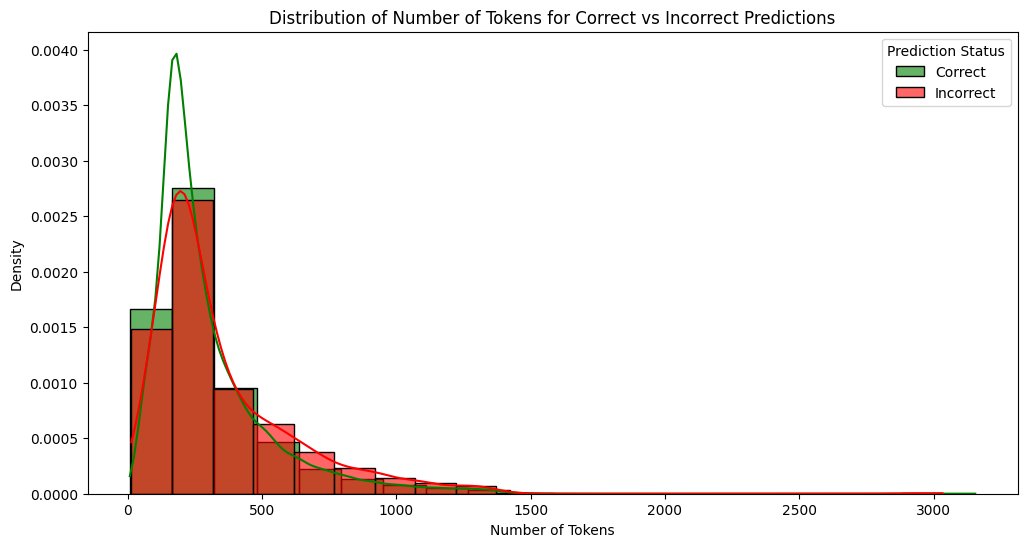

In [27]:
# Plot the distributions using seaborn
plt.figure(figsize=(12, 6))

# Correct tokens distribution
sns.histplot(correct_df["num_tokens"], color='green', label='Correct', kde=True, stat="density", bins=20, alpha=0.6)

# Incorrect tokens distribution
sns.histplot(incorrect_df["num_tokens"], color='red', label='Incorrect', kde=True, stat="density", bins=20, alpha=0.6)

plt.title("Distribution of Number of Tokens for Correct vs Incorrect Predictions")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.legend(title="Prediction Status")
plt.show()

In [32]:
# Calculate proportions of reviews with 'was_truncated' as True
correct_over_512_proportion = len(correct_df[correct_df["was_truncated"] == True]) / len(correct_df)
incorrect_over_512_proportion = len(incorrect_df[incorrect_df["was_truncated"] == True]) / len(incorrect_df)

# Print the proportions
print(f"Proportion of correctly classified reviews with over 512 tokens: {correct_over_512_proportion:.4f}")
print(f"Proportion of incorrectly classified reviews with over 512 tokens: {incorrect_over_512_proportion:.4f}")

Proportion of correctly classified reviews with over 512 tokens: 0.1344
Proportion of incorrectly classified reviews with over 512 tokens: 0.2054


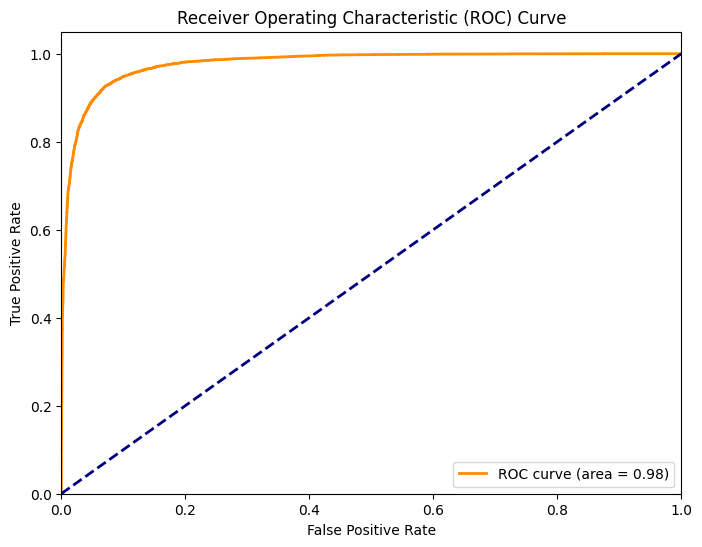

In [28]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# Step 1: Get true labels and predicted probabilities
# True labels are in 'true_label' column
labels = scored_df["true_label"].values

# Predicted probabilities for the positive class are in 'positive_score' column
# Since we already have the probabilities, no need to apply softmax again.
probs = scored_df["positive_score"].values

# Step 2: Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# PART II : using LIME to further analyze the results

In [29]:
!pip install lime

In [33]:
# Importing the necessary library and create an empty cache
from lime.lime_text import LimeTextExplainer
import gc
import joblib
from collections import Counter

torch.cuda.empty_cache()

lime_cache_file = "lime_cache.pkl"
try:
    lime_cache = joblib.load(lime_cache_file)
    print(f"Loaded {len(lime_cache)} cached explanations")
except:
    lime_cache = {}
    print("Created new LIME explanation cache")

Created new LIME explanation cache


In [34]:
# Loading our fine-tuned model and tokenizer
model_save_path = "./imdb_sentiment_model"  # Path where we saved the model
model = DistilBertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_save_path)

# Moving model to the right device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setting model to evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [35]:
# Function necessary in LIME explanation, to get the probabilities for the positive class
def predict_proba_lime(texts):
    # Ensure the model is on CPU for LIME predictions
    model_cpu = model.to("cpu")
    
    # Process inputs in smaller batches
    batch_size = 8
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Reduce max_length to save memory (e.g., 256 tokens)
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                         return_tensors="pt", max_length=256)
        
        with torch.no_grad():
            outputs = model_cpu(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.numpy())
    
    return np.vstack(all_probs) if len(all_probs) > 1 else all_probs[0]

In [36]:
# Define the LIME explainer
class_names = ["Negative", "Positive"]
explainer = LimeTextExplainer(class_names=class_names, split_expression='\W+')

# Function to get or compute LIME explanation
def get_or_compute_explanation(idx, num_features=5):
    cache_key = f"{idx}_{num_features}"
    if cache_key in lime_cache:
        return lime_cache[cache_key]
    
    # Get the text from the dataframe
    text = scored_df.loc[idx,'review']
    
    # Generate LIME explanation with reduced samples
    explanation = explainer.explain_instance(
        text,
        predict_proba_lime,
        num_features=min(num_features, len(text.split())),
        num_samples=500,  # Reduced from default 5000 to save memory
        top_labels=2
    )
    
    # Cache the result
    lime_cache[cache_key] = explanation
    if len(lime_cache) % 5 == 0:  # Save cache periodically
        joblib.dump(lime_cache, lime_cache_file)
    
    return explanation

In [37]:
# Function to analyze a specific misclassified example
def analyze_classification(idx, num_features=5):
    # Move model to CPU and clear memory
    model.to("cpu")
    torch.cuda.empty_cache()
    gc.collect()

    text = scored_df.loc[idx, 'review'] #voir si redondance à corriger ?
    
    print(f"\n{'='*80}")
    print(f"ANALYZING THE EXAMPLE #{idx}")
    print(f"{'='*80}")
    show_example_predictions(scored_df.loc[[idx]], num_examples=1)
    print("-" * 80)
   
    # Get explanation (from cache or compute new)
    explanation = get_or_compute_explanation(idx, num_features)

    # Analyze both classes to understand why the misclassification happened
    for label_id in [0, 1]:  # 0: Negative, 1: Positive
        label_name = class_names[label_id]
        print(f"\nFeature importance for class: {label_name}")

        # Get the words and their weights
        feature_importance = explanation.as_list(label_id)

        # Sort by absolute weight for better visualization
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

        # Text-based visualization instead of matplotlib
        print(f"Top words driving {label_name} prediction:")
        for word, weight in feature_importance[:10]:
            impact = "increasing" if weight > 0 else "decreasing"
            print(f"  • '{word}': {weight:.4f} ({impact} probability)")

    # Identify words in context
    print("\nWords in context:")
    for word, _ in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:5]:
        # Simple approach to find word in context (not perfect for subwords)
        lower_text = text.lower()
        word_lower = word.lower()
        start_pos = lower_text.find(word_lower)
        if start_pos != -1:
            # Get some context around the word
            context_start = max(0, start_pos - 50)
            context_end = min(len(text), start_pos + len(word) + 50)

            context = text[context_start:context_end]
            # Highlight the word in the context
            highlighted = context.replace(word, f"**{word}**")
            print(f"  • Context: \"...{highlighted}...\"")

    # Clear memory again
    torch.cuda.empty_cache()
    gc.collect()
    
    return explanation

In [38]:
# Batch processing for misclassifications
def analyze_misclassifications_batch(num_examples=3, batch_size=2):
    # Ensure correct indices are selected from the incorrect_df
    indices = np.random.choice(incorrect_df.index, min(num_examples, len(incorrect_df)), replace=False)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_classification(idx)  # Analyze the example using the correct index from scored_df
        
        # Clear memory after each batch
        model.to("cpu")
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Completed batch {i//batch_size + 1}/{(len(indices) + batch_size - 1)//batch_size}")


In [39]:
def analyze_confident_misclassifications(num_examples=3, batch_size=2):
    if incorrect_df.empty:
        print("No misclassified examples found.")
        return

    # Get the top 100 most confident incorrect predictions
    top_incorrect = incorrect_df.sort_values(by="confidence", ascending=False).head(100)

    # Then pick the most confident among them
    selected_indices = top_incorrect.index[:num_examples]

    # Analyze in batches
    print(f"\n{'='*80}")
    print(f"ANALYZING MOST CONFIDENT MISCLASSIFICATIONS")
    print(f"{'='*80}")

    for i in range(0, len(selected_indices), batch_size):
        batch_indices = selected_indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_classification(idx)
        
        # Clear memory after each batch
        torch.cuda.empty_cache()
        gc.collect()


In [40]:
def analyze_misclassification_patterns(max_examples=20):
    if incorrect_df.empty:
        print("No misclassified examples found.")
        return

    word_frequency = Counter()

    # Limit examples
    for idx in incorrect_df.index[:max_examples]:
        text = incorrect_df.loc[idx, 'review']
        words = set(text.lower().split())
        word_frequency.update(words)

    print("\nCommon words in misclassified examples:")
    for word, count in word_frequency.most_common(10):
        if len(word) > 2:
            print(f"'{word}': {count}")

    print("\nPotentially problematic words:")
    for word, count in word_frequency.most_common(50):
        if len(word) > 3 and count > max_examples / 3:
            examples = []
            for idx in incorrect_df.index[:max_examples]:
                text = incorrect_df.loc[idx, 'review'].lower()
                if word in text.split():
                    true_label = "Positive" if incorrect_df.loc[idx, 'true_label'] == 1 else "Negative"
                    pred_label = "Positive" if incorrect_df.loc[idx, 'predicted_label'] == 1 else "Negative"
                    examples.append((true_label, pred_label))
                    if len(examples) >= 3:
                        break
            if examples:
                print(f"'{word}': {count} occurrences - Examples: {examples}")


In [41]:
# Run the analysis with improved memory management
print("Starting optimized LIME analysis of misclassified examples...")
analyze_misclassifications_batch(3, batch_size=1)  # Analyze 3 random misclassifications, 1 at a time

print("\nAnalyzing patterns in misclassifications...")
analyze_misclassification_patterns(20)

print("\nAnalyzing the most confident misclassifications...")
analyze_confident_misclassifications(3, batch_size=1)  # Analyze 3 most confident misclassifications, 1 at a time

# Save final cache
joblib.dump(lime_cache, lime_cache_file)
print(f"\nSaved {len(lime_cache)} explanations to cache")

Starting optimized LIME analysis of misclassified examples...

ANALYZING THE EXAMPLE #9781
Index: 9781
Review (first 200 chars): I swore I would never allow myself to devolve into to the bogus authority figures of the sixties who told me things were better in the "good old days"  the current Australian Prime Minister is a sord...
True Sentiment: Positive
Predicted Sentiment: Negative (Confidence: 0.9986)
Positive Score: 0.0014
Number of tokens: 764
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Feature importance for class: Negative
Top words driving Negative prediction:
  • 'devoid': 0.0681 (increasing probability)
  • 'big': 0.0520 (increasing probability)
  • 'misled': 0.0428 (increasing probability)
  • 'lacking': 0.0428 (increasing probability)
  • 'swore': 0.0428 (increasing probability)

Feature importance for class: Positive
Top words driving Positive prediction: